In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd 
import torch
from sentence_transformers import models, losses, evaluation, SentenceTransformer
import os
import json
from transformers import BertJapaneseTokenizer, BertModel
import pickle

from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from modules import meishi,wakachi
import mojimoji

In [23]:
from modules import one_hot, ShowList,makeAug

In [33]:
df = pd.read_csv("CSVs/CorrectedDatanew.csv")

In [34]:
# 半角、スペース、小文字修正
df['diagnosis'] = df['diagnosis'].map(mojimoji.zen_to_han)
df['purpose'] = df['purpose'].map(mojimoji.zen_to_han)
df['diagnosis']=df['diagnosis'].str.replace(' ', '')
df['purpose']=df['purpose'].str.replace(' ', '')
df['diagnosis']=df['diagnosis'].str.lower()
df['purpose']=df['purpose'].str.lower()

In [35]:
df.columns

Index(['year', 'section', 'label', 'position', 'purpose', 'diagnosis', '男',
       '女', '単純', '造影'],
      dtype='object')

In [36]:
#df = df[:100]
#行を全表示（行の数）
pd.set_option("display.max_rows", len(df))


#列を全表示（列の数）
pd.set_option("display.max_columns", len(df))

###　diagnosis（単語群）の変形

In [37]:
# m名詞のみに変形
df['new_diagnosis'] = df['diagnosis'].copy().apply(meishi)

In [38]:
# 重複をなくす
df['new_diagnosis']=df['new_diagnosis'].map(set)
df['new_diagnosis']=df['new_diagnosis'].map(list)

In [39]:
# fasttextをインスタンス化
from modules import FastText_Vectrizer
FT=FastText_Vectrizer("../data/model/fasttext_meishi_model_100.bin")
Tovec = FT.Vectrizer

In [40]:
# new_diagnosis（名詞群）をベクトル化し平均をdfに追加
df_vec = df['new_diagnosis'].apply(Tovec)

In [41]:
# カラム名を変更する
df_vec=list(df_vec)
num=df_vec[0].shape[0]
col_name = ["Dvec"+str(i) for i in range(num)]
df_vec=pd.DataFrame(df_vec,columns=col_name)
df = pd.concat([df,df_vec],axis=1)

In [42]:
#diagnosisのみ変形語
df.to_csv("CSVs/data(diagnosi).csv")

### purpose（文書）の変形 
### １sentenceBERT

In [43]:
df = pd.read_csv("CSVs/data(diagnosi).csv")

In [44]:
len(df)

18857

In [45]:
# sBERTファインチューニングしたのモデル
MODEL_NAME = "../data/model/strf_sonoisa_sentence-bert-base-ja-mean-tokens-v232.75.10"
word_embedding_model = models.Transformer(MODEL_NAME, max_seq_length=75)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# 学習データを上のモデルでベクトル変換したデータ
train_embeddings=np.load('../data/exam_data/sonoisa_vec/sbvec_so.npy')

# 主成分分析モデルの作成
pca = PCA(n_components=0.9)
pca.fit(train_embeddings)
pca_comp = np.asarray(pca.components_)
#pcaのパラメータ保存
np.save('pca_comp_BERT', pca_comp)
#pca_comp=np.load('pca_comp.npy')
# 主成分分析モデルをBERTの最後に足す
new_dimension=139    
dense = models.Dense(in_features=model.get_sentence_embedding_dimension(), 
                     out_features=new_dimension, bias=False, 
                     activation_function=torch.nn.Identity())
dense.linear.weight = torch.nn.Parameter(torch.tensor(pca_comp))
model.add_module('dense', dense)

In [46]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 75, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (dense): Dense({'in_features': 768, 'out_features': 139, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)

# modelの保存
pd.to_pickle(model, 'smodel.pkl')

smodel_read_pickle = pd.read_pickle("smodel.pkl") 
smodel_read_pickle

In [47]:
#カラム名変更
sBERT = model.encode(df["purpose"])
sBERT=list(sBERT)
num=sBERT[0].shape[0]
col_name = ["P(S)vec"+str(i) for i in range(num)]
sBERT=pd.DataFrame(sBERT,columns=col_name)
df_sBERT = pd.concat([df,sBERT],axis=1)

In [48]:
# ベクトルデータへ変換後のデータを保存
df_sBERT.to_csv("CSVs/sBERT_data.csv")

### purpose（文書）の変形 
### 2 fasttext300 

#fasttextモデル学習
model= fasttext.train_unsupervised(input='fasttrain_train_meishi.txt',dim=300, ws=7 ,model='skipgram', neg=8, 
                                   epoch=10 ,minCount=1,minn=0 ,wordNgrams=0)#model{cbow, skipgram}
model.save_model('fasttext_meishi_model.bin')

In [22]:
df = pd.read_csv("data(diagnosi).csv")

In [23]:
# fasttextをインスタンス化
from modules import FastText_Vectrizer
FT=FastText_Vectrizer("../data/model/fasttext_meishi_model.bin")
Tovec = FT.Vectrizer

In [24]:
# new_diagnosis（名詞群）をベクトル化し平均をdfに追加
df_vec = df['purpose'].apply(Tovec)

In [25]:
# カラム名を変更する
df_vec=list(df_vec)
num=df_vec[0].shape[0]
col_name = ["P(f)vec"+str(i) for i in range(num)]
df_vec=pd.DataFrame(df_vec,columns=col_name)
df_ft = pd.concat([df,df_vec],axis=1)

In [32]:
# ベクトルデータへ変換後のデータを保存
df_ft.to_csv("CSVs/ft_data.csv")

### データセットsBERT

In [15]:
df_sBERT=pd.read_csv("CSVs/sBERT_data.csv")
df_ft=pd.read_csv("CSVs/ft_data.csv")

df_sBERT=df_sBERT.drop(["Unnamed: 0", 'purpose', 'diagnosis',], axis=1)
df_ft=df_ft.drop(["Unnamed: 0", 'purpose', 'diagnosis',], axis=1)
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
df = df_sBERT
len(df)

18857

In [216]:
# カテゴリカルデータをラベルエンコード
from sklearn import preprocessing
lbl_s = preprocessing.LabelEncoder()
lbl_s.fit(df['section'])
lbl_section = lbl_s.transform(df['section'])

lbl_p = preprocessing.LabelEncoder()
lbl_p.fit(df['position'])
lbl_position = lbl_p.transform(df['position'])

lbl_l = preprocessing.LabelEncoder()
lbl_l.fit(df['label'])
lbl_label = lbl_l.transform(df['label'])

In [236]:
y = lbl_label
X = df.drop(['Unnamed: 0.1', 'label', 'section', 'position', 'new_diagnosis'], axis=1)
X['sec_lbl'] = lbl_section
X['pos_lbl'] = lbl_position
#X['label_lbl'] = lbl_label


print(np.unique(y), len(np.unique(y)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] 55


In [238]:
#学習データ、テストデータ、検証データ作成

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=0, stratify=y)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train , test_size=0.3, random_state=0, stratify=y_train)

In [261]:
#weightをつける
#https://qastack.jp/datascience/16342/unbalanced-multiclass-data-with-xgboost
#https://qiita.com/shinji_komine/items/0d3b780ea522c7a6dec3
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced', 
                                                       classes=np.unique(y_train),
                                                       y=y_train)
                    )
w_array = np.ones(y_train.shape[0], dtype = 'float16')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]

### データセット fasttext

In [17]:
df = df_ft
len(df)

18857

In [18]:
# カテゴリカルデータをラベルエンコード
from sklearn import preprocessing
lbl_s = preprocessing.LabelEncoder()
lbl_s.fit(df['section'])
lbl_section = lbl_s.transform(df['section'])

lbl_p = preprocessing.LabelEncoder()
lbl_p.fit(df['position'])
lbl_position = lbl_p.transform(df['position'])

lbl_l = preprocessing.LabelEncoder()
lbl_l.fit(df['label'])
lbl_label = lbl_l.transform(df['label'])

In [20]:
yf = lbl_label
Xf = df.drop(['Unnamed: 0.1', 'label', 'section', 'position', 'new_diagnosis'], axis=1)
Xf['sec_lbl'] = lbl_section
Xf['pos_lbl'] = lbl_position
#X['label_lbl'] = lbl_label


print(np.unique(yf), len(np.unique(yf)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] 55


In [24]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf , test_size=0.3, random_state=0, stratify=yf)
Xf_train, Xf_eval, yf_train, yf_eval = train_test_split(Xf_train, yf_train , test_size=0.3, random_state=0, stratify=yf_train)

In [29]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced', 
                                                       classes=np.unique(yf_train),
                                                       y=yf_train)
                    )
w_array = np.ones(yf_train.shape[0], dtype = 'float16')
for i, val in enumerate(yf_train):
    w_array[i] = class_weights[val]

### lgb sBERT

#https://an-engineer-note.com/?p=312

In [25]:
# カテゴリー変数
categorical_features = {*sorted(['pos_lbl', 'sec_lbl'])}

In [26]:
categorical_features

{'pos_lbl', 'sec_lbl'}

In [264]:
lgb_train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        free_raw_data=False,
                        weight=w_array
                        )
# 検証用
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False,
                       weight=np.ones(len(X_eval)).astype('float16'))

In [32]:
params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
          'boosting_type': 'gbdt',        # 勾配ブースティング
          'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
          'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
          'num_class': 55,                 # 目的変数のクラス数
          'learning_rate': 0.02,          # 学習率（初期値0.1）
          'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
          'min_data_in_leaf': 1,          # データの最小数（初期値20）
         }

In [266]:
# 学習
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgb.train(params,                                   # 上記で設定したパラメータ
                  lgb_train,                                # 使用するデータセット
                  num_boost_round=1000,                     # 学習の回数
                  valid_names=['train', 'valid'],           # 学習経過で表示する名称
                  valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                  evals_result=evaluation_results,          # 学習の経過を保存
                  categorical_feature=categorical_features, # カテゴリー変数を設定
                  early_stopping_rounds=20,                 # アーリーストッピング
                  verbose_eval=10)                          # 学習の経過の表示(10回毎)

# 最もスコアが良いときのラウンドを保存
optimum_boost_rounds = model.best_iteration

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and w

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61072
[LightGBM] [Info] Number of data points in the train set: 9239, number of used features: 246
[LightGBM] [Info] Start training from score -4.007013
[LightGBM] [Info] Start training from score -4.007478
[LightGBM] [Info] Start training from score -4.007536
[LightGBM] [Info] Start training from score -4.007216
[LightGBM] [Info] Start training from score -4.007245
[LightGBM] [Info] Start training from score -4.007385
[LightGBM] [Info] Start training from score -4.007382
[LightGBM] [Info] Start training from score -4.007292
[LightGBM] [Info] Start training from score -4.007385
[LightGBM] [Info] Start training from score -4.007257
[LightGBM] [Info] Start training from score -4.007245
[LightGBM] [Info] Start training from score -4.007222
[LightGBM] [Info] Start training from score -4.006969
[Ligh

/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[10]	train's multi_logloss: 1.50962	valid's multi_logloss: 2.02549
[20]	train's multi_logloss: 0.941993	valid's multi_logloss: 1.52578
[30]	train's multi_logloss: 0.627386	valid's multi_logloss: 1.23689
[40]	train's multi_logloss: 0.429821	valid's multi_logloss: 1.04839
[50]	train's multi_logloss: 0.299749	valid's multi_logloss: 0.920095
[60]	train's multi_logloss: 0.211271	valid's multi_logloss: 0.827361
[70]	train's multi_logloss: 0.150609	valid's multi_logloss: 0.76196
[80]	train's multi_logloss: 0.108413	valid's multi_logloss: 0.712948
[90]	train's multi_logloss: 0.0788328	valid's multi_logloss: 0.67781
[100]	train's multi_logl

In [268]:
# テストデータで予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# Accuracy の計算
accuracy = sum(y_test == y_pred_max) / len(y_test)
print('accuracy:', accuracy)

# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])
display(importance)

accuracy: 0.8584305408271474


,importance
year,8067
男,548
女,202
単純,968
造影,247
Dvec0,2982
Dvec1,2618
Dvec2,1150
Dvec3,2245
Dvec4,1370


In [269]:
np.set_printoptions(suppress=True) 
print(y_pred)

[[0.00005518 0.00005512 0.00005553 ... 0.00005512 0.00005517 0.00005515]
 [0.00007381 0.00007376 0.00007431 ... 0.00007375 0.0000738  0.00007378]
 [0.0008942  0.00089572 0.00090245 ... 0.00089561 0.00089425 0.00089487]
 ...
 [0.00022029 0.00022078 0.00022244 ... 0.00022075 0.00022031 0.00022032]
 [0.00022071 0.00022052 0.00022159 ... 0.00022049 0.00022061 0.00022062]
 [0.00036419 0.00036498 0.00036772 ... 0.00036493 0.00036419 0.00036443]]


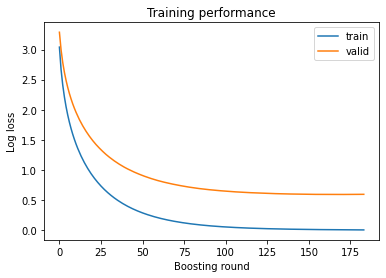

In [270]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance(sBERT)')
plt.legend()
plt.show()

#https://potesara-tips.com/lightgbm-holdout/
#https://potesara-tips.com/lightgbm-k-fold-cross-validation/

In [ ]:
print(classification_report(y_pred_max, y_test))

### lgb fasttext

In [31]:
lgb_train = lgb.Dataset(Xf_train, yf_train,
                        categorical_feature=categorical_features,
                        free_raw_data=False,
                        weight=w_array
                        )
# 検証用
lgb_eval = lgb.Dataset(Xf_eval, yf_eval, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False,
                       weight=np.ones(len(Xf_eval)).astype('float16'))

In [ ]:
params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
          'boosting_type': 'gbdt',        # 勾配ブースティング
          'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
          'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
          'num_class': 55,                 # 目的変数のクラス数
          'learning_rate': 0.02,          # 学習率（初期値0.1）
          'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
          'min_data_in_leaf': 1,          # データの最小数（初期値20）
         }

In [33]:
# 学習
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgb.train(params,                                   # 上記で設定したパラメータ
                  lgb_train,                                # 使用するデータセット
                  num_boost_round=1000,                     # 学習の回数
                  valid_names=['train', 'valid'],           # 学習経過で表示する名称
                  valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                  evals_result=evaluation_results,          # 学習の経過を保存
                  categorical_feature=categorical_features, # カテゴリー変数を設定
                  early_stopping_rounds=20,                 # アーリーストッピング
                  verbose_eval=10)                          # 学習の経過の表示(10回毎)

# 最もスコアが良いときのラウンドを保存
optimum_boost_rounds = model.best_iteration

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and w

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102115
[LightGBM] [Info] Number of data points in the train set: 9239, number of used features: 407
[LightGBM] [Info] Start training from score -4.007013
[LightGBM] [Info] Start training from score -4.007478
[LightGBM] [Info] Start training from score -4.007536
[LightGBM] [Info] Start training from score -4.007216
[LightGBM] [Info] Start training from score -4.007245
[LightGBM] [Info] Start training from score -4.007385
[LightGBM] [Info] Start training from score -4.007382
[LightGBM] [Info] Start training from score -4.007292
[LightGBM] [Info] Start training from score -4.007385
[LightGBM] [Info] Start training from score -4.007257
[LightGBM] [Info] Start training from score -4.007245
[LightGBM] [Info] Start training from score -4.007222
[LightGBM] [Info] Start training from score -4.006969
[Lig

/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[10]	train's multi_logloss: 1.50785	valid's multi_logloss: 2.02827
[20]	train's multi_logloss: 0.940379	valid's multi_logloss: 1.52662
[30]	train's multi_logloss: 0.625959	valid's multi_logloss: 1.23978
[40]	train's multi_logloss: 0.428269	valid's multi_logloss: 1.05267
[50]	train's multi_logloss: 0.297761	valid's multi_logloss: 0.923695
[60]	train's multi_logloss: 0.209601	valid's multi_logloss: 0.831474
[70]	train's multi_logloss: 0.149086	valid's multi_logloss: 0.76513
[80]	train's multi_logloss: 0.10709	valid's multi_logloss: 0.716916
[90]	train's multi_logloss: 0.0777383	valid's multi_logloss: 0.68103
[100]	train's multi_loglo

In [35]:
# テストデータで予測
yf_pred = model.predict(Xf_test, num_iteration=model.best_iteration)
yf_pred_max = np.argmax(yf_pred, axis=1)

# Accuracy の計算
accuracy = sum(yf_test == yf_pred_max) / len(yf_test)
print('accuracy:', accuracy)

# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(), index=Xf.columns, columns=['importance'])
display(importance)

accuracy: 0.8612583951926476


,importance
year,8594
男,506
女,203
単純,1395
造影,242
Dvec0,2948
Dvec1,2437
Dvec2,1437
Dvec3,2488
Dvec4,1389


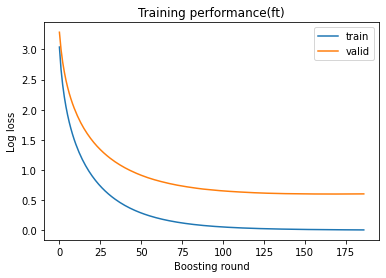

In [36]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance(ft)')
plt.legend()
plt.show()

#https://potesara-tips.com/lightgbm-holdout/
#https://potesara-tips.com/lightgbm-k-fold-cross-validation/

In [ ]:
print(classification_report(yf_pred_max, yf_test))

In [66]:
a=classification_report(yf_pred_max, yf_test, output_dict=True)
a['0']

{'precision': 0.6666666666666666,
 'recall': 0.6666666666666666,
 'f1-score': 0.6666666666666666,
 'support': 6}

### NN

In [69]:
Xf.head()

,year,男,女,単純,造影,Dvec0,Dvec1,Dvec2,Dvec3,Dvec4,Dvec5,Dvec6,Dvec7,Dvec8,Dvec9,Dvec10,Dvec11,Dvec12,Dvec13,Dvec14,Dvec15,Dvec16,Dvec17,Dvec18,Dvec19,Dvec20,Dvec21,Dvec22,Dvec23,Dvec24,Dvec25,Dvec26,Dvec27,Dvec28,Dvec29,Dvec30,Dvec31,Dvec32,Dvec33,Dvec34,Dvec35,Dvec36,Dvec37,Dvec38,Dvec39,Dvec40,Dvec41,Dvec42,Dvec43,Dvec44,Dvec45,Dvec46,Dvec47,Dvec48,Dvec49,Dvec50,Dvec51,Dvec52,Dvec53,Dvec54,Dvec55,Dvec56,Dvec57,Dvec58,Dvec59,Dvec60,Dvec61,Dvec62,Dvec63,Dvec64,Dvec65,Dvec66,Dvec67,Dvec68,Dvec69,Dvec70,Dvec71,Dvec72,Dvec73,Dvec74,Dvec75,Dvec76,Dvec77,Dvec78,Dvec79,Dvec80,Dvec81,Dvec82,Dvec83,Dvec84,Dvec85,Dvec86,Dvec87,Dvec88,Dvec89,Dvec90,Dvec91,Dvec92,Dvec93,Dvec94,Dvec95,Dvec96,Dvec97,Dvec98,Dvec99,P(f)vec0,P(f)vec1,P(f)vec2,P(f)vec3,P(f)vec4,P(f)vec5,P(f)vec6,P(f)vec7,P(f)vec8,P(f)vec9,P(f)vec10,P(f)vec11,P(f)vec12,P(f)vec13,P(f)vec14,P(f)vec15,P(f)vec16,P(f)vec17,P(f)vec18,P(f)vec19,P(f)vec20,P(f)vec21,P(f)vec22,P(f)vec23,P(f)vec24,P(f)vec25,P(f)vec26,P(f)vec27,P(f)vec28,P(f)vec29,P(f)vec30,P(f)vec31,P(f)vec32,P(f)vec33,P(f)vec34,P(f)vec35,P(f)vec36,P(f)vec37,P(f)vec38,P(f)vec39,P(f)vec40,P(f)vec41,P(f)vec42,P(f)vec43,P(f)vec44,P(f)vec45,P(f)vec46,P(f)vec47,P(f)vec48,P(f)vec49,P(f)vec50,P(f)vec51,P(f)vec52,P(f)vec53,P(f)vec54,P(f)vec55,P(f)vec56,P(f)vec57,P(f)vec58,P(f)vec59,P(f)vec60,P(f)vec61,P(f)vec62,P(f)vec63,P(f)vec64,P(f)vec65,P(f)vec66,P(f)vec67,P(f)vec68,P(f)vec69,P(f)vec70,P(f)vec71,P(f)vec72,P(f)vec73,P(f)vec74,P(f)vec75,P(f)vec76,P(f)vec77,P(f)vec78,P(f)vec79,P(f)vec80,P(f)vec81,P(f)vec82,P(f)vec83,P(f)vec84,P(f)vec85,P(f)vec86,P(f)vec87,P(f)vec88,P(f)vec89,P(f)vec90,P(f)vec91,P(f)vec92,P(f)vec93,P(f)vec94,P(f)vec95,P(f)vec96,P(f)vec97,P(f)vec98,P(f)vec99,P(f)vec100,P(f)vec101,P(f)vec102,P(f)vec103,P(f)vec104,P(f)vec105,P(f)vec106,P(f)vec107,P(f)vec108,P(f)vec109,P(f)vec110,P(f)vec111,P(f)vec112,P(f)vec113,P(f)vec114,P(f)vec115,P(f)vec116,P(f)vec117,P(f)vec118,P(f)vec119,P(f)vec120,P(f)vec121,P(f)vec122,P(f)vec123,P(f)vec124,P(f)vec125,P(f)vec126,P(f)vec127,P(f)vec128,P(f)vec129,P(f)vec130,P(f)vec131,P(f)vec132,P(f)vec133,P(f)vec134,P(f)vec135,P(f)vec136,P(f)vec137,P(f)vec138,P(f)vec139,P(f)vec140,P(f)vec141,P(f)vec142,P(f)vec143,P(f)vec144,P(f)vec145,P(f)vec146,P(f)vec147,P(f)vec148,P(f)vec149,P(f)vec150,P(f)vec151,P(f)vec152,P(f)vec153,P(f)vec154,P(f)vec155,P(f)vec156,P(f)vec157,P(f)vec158,P(f)vec159,P(f)vec160,P(f)vec161,P(f)vec162,P(f)vec163,P(f)vec164,P(f)vec165,P(f)vec166,P(f)vec167,P(f)vec168,P(f)vec169,P(f)vec170,P(f)vec171,P(f)vec172,P(f)vec173,P(f)vec174,P(f)vec175,P(f)vec176,P(f)vec177,P(f)vec178,P(f)vec179,P(f)vec180,P(f)vec181,P(f)vec182,P(f)vec183,P(f)vec184,P(f)vec185,P(f)vec186,P(f)vec187,P(f)vec188,P(f)vec189,P(f)vec190,P(f)vec191,P(f)vec192,P(f)vec193,P(f)vec194,P(f)vec195,P(f)vec196,P(f)vec197,P(f)vec198,P(f)vec199,P(f)vec200,P(f)vec201,P(f)vec202,P(f)vec203,P(f)vec204,P(f)vec205,P(f)vec206,P(f)vec207,P(f)vec208,P(f)vec209,P(f)vec210,P(f)vec211,P(f)vec212,P(f)vec213,P(f)vec214,P(f)vec215,P(f)vec216,P(f)vec217,P(f)vec218,P(f)vec219,P(f)vec220,P(f)vec221,P(f)vec222,P(f)vec223,P(f)vec224,P(f)vec225,P(f)vec226,P(f)vec227,P(f)vec228,P(f)vec229,P(f)vec230,P(f)vec231,P(f)vec232,P(f)vec233,P(f)vec234,P(f)vec235,P(f)vec236,P(f)vec237,P(f)vec238,P(f)vec239,P(f)vec240,P(f)vec241,P(f)vec242,P(f)vec243,P(f)vec244,P(f)vec245,P(f)vec246,P(f)vec247,P(f)vec248,P(f)vec249,P(f)vec250,P(f)vec251,P(f)vec252,P(f)vec253,P(f)vec254,P(f)vec255,P(f)vec256,P(f)vec257,P(f)vec258,P(f)vec259,P(f)vec260,P(f)vec261,P(f)vec262,P(f)vec263,P(f)vec264,P(f)vec265,P(f)vec266,P(f)vec267,P(f)vec268,P(f)vec269,P(f)vec270,P(f)vec271,P(f)vec272,P(f)vec273,P(f)vec274,P(f)vec275,P(f)vec276,P(f)vec277,P(f)vec278,P(f)vec279,P(f)vec280,P(f)vec281,P(f)vec282,P(f)vec283,P(f)vec284,P(f)vec285,P(f)vec286,P(f)vec287,P(f)vec288,P(f)vec289,P(f)vec290,P(f)vec291,P(f)vec292,P(f)vec293,P(f)vec294,P(f)vec295,P(f)vec296,P(f)vec297,P(f)vec298,P(f)vec299,sec_lbl,pos_lbl
0,46,1,0,1,0,0.5450,0.8726,0.7446,-0.43120,0.27170,0.09326,-0.49800,-0.7144,-0.1032,0.08

In [71]:
y[:5]

array([12, 12, 12,  0,  0])

In [ ]:
# encordingの変更

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
import torchmetrics

In [73]:
import tensorflow as tf
from tensorflow import keras

2022-11-14 12:25:13.849339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 12:25:15.325097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 12:25:15.326439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-14 12:25:15.668981: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 12:25:27.714334: W tensorflow/stream_executor/platform/de

In [ ]:
#出力の形式
#回帰：float32
#二値分類：float32
#多値分類：int64

In [51]:
len(X.columns)

407

In [ ]:
x = torch.tensor(x, dtype=torch.float32)

In [ ]:
y=np.array(y)

In [ ]:
y = torch.tensor(y, dtype=torch.int64)

In [ ]:
dataset = torch.utils.data.TensorDataset(x, y)

In [ ]:
len(dataset)

In [ ]:
n_train = int(len(dataset) * 0.6)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val

torch.manual_seed(0)

train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

In [ ]:
len(train), len(val), len(test)

In [ ]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [ ]:
x, t = next(iter(train_loader))
print(x.shape,t.shape)

In [ ]:
fc1 = nn.Linear(260, 100)
dr1 = nn.Dropout(p=0.2)
fc2 = nn.Linear(100, 10)
dr2 = nn.Dropout(p=0.2)
fc3 = nn.Linear(10, 1)

In [ ]:
h = fc1(x)
h = dr1(h)
h = fc2(h)
h=  dr2(h)
h=  fc3(h)

In [ ]:
h.shape

In [ ]:
h = h.squeeze(1)

In [ ]:
h.shape

In [ ]:
h.shape

In [ ]:
t.shape

In [ ]:
y = t.unsqueeze(1)
y.shape

In [ ]:
class Net(pl.LightningModule):
    



    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(260, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.dr1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(100, 10)
        self.bn2 = nn.BatchNorm1d(10)
        self.dr2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(10, 1)


    def forward(self, h):
        h = self.fc1(h)
        h = self.bn1(h)
        h = self.dr1(h)
        h = self.fc2(h)
        h = self.bn2(h)
        h = self.dr2(h)
        h = self.fc3(h)
        
        h = h.squeeze(1)        

        return h


    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        
        
        loss = F.mse_loss(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    # 検証データに対する処理
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        
        
        loss = F.mse_loss(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss


    # テストデータに対する処理
    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        
        
        loss = F.mse_loss(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss




    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

In [ ]:
# 乱数のシードを固定して再現性を確保
pl.seed_everything(0)

# インスタンス化
net = Net()
net

In [ ]:
trainer = pl.Trainer(max_epochs=5)

In [ ]:
trainer.fit(net, train_loader, val_loader)

In [ ]:
#logはここに格納される
trainer.callback_metrics

In [ ]:
#モデルをテストデータで検証
results = trainer.test(dataloaders=test_loader)

In [ ]:
results

In [ ]:
trainer.callback_metrics

In [ ]:
x, t = next(iter(train_loader))

In [ ]:
t

In [ ]:
net.forward(x)

In [ ]:
import optuna

In [ ]:
#xgBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(x_train, y_train)

In [ ]:
y_test_pred =reg_xgb.predict(x_test)

In [ ]:
y_train_pred = reg_xgb.predict(x_train)

In [ ]:
y_val_pred = reg_xgb.predict(x_val)

In [ ]:
fig = plt.figure(figsize=(14, 10))

fig.add_subplot(1, 3,2)
plt.title("valid")
sns.scatterplot(x=y_val, y=y_val_pred)
plt.xlim(-5, 80)
plt.ylim(-5, 80)
plt.xlabel("true")
plt.ylabel("pred")
plt.grid()

fig.add_subplot(1, 3,1)
plt.title("test")
sns.scatterplot(x=y_test, y=y_test_pred)
plt.xlim(-5, 80)
plt.ylim(-5, 80)
plt.xlabel("true")
plt.ylabel("pred")
plt.grid()

fig.add_subplot(1, 3,3)
plt.title("train")
sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlim(-5, 80)
plt.ylim(-5, 80)
plt.xlabel("true")
plt.ylabel("pred")
plt.grid()